**Date** 23/11/2025
**Author** Jordi Torres
Core code based on work by professor Gaillard. 

**EXERCISE 1** Ayagari + employment status

In [9]:
#libraries 

using Printf;
using Roots;
using Plots;

#wider page display
display("text/html", "<style>.container { width:100% !important; }</style>")

**Variables fixed**

In [10]:
const size_k 	= 1000;    #number of grid points     
const size_m 	= 7;       #number of productivity classes

const size_e =2 ; #added!

const kmin 		= 0.0;
const kmax 		= 1700.0;

const betapar 	= 0.96;
const alphapar 	= 0.36;
const deltapar 	= 0.08;
const rhopar 	= 3.0;
const labor 	= 1.0219882;

const epsV 		= 1.0e-8;
const epsdist 	= 1.0e-10;
const epsK		= 1.0e-6;
const relaxsK 	= 0.01;

## grid constants
const scale1 = 1.6;
const grmin = (kmin/scale1)-1.0;
const exponen=log((kmax/scale1)-grmin)/(size_k-1);

const sstates = [exp(-0.600000000000000)	  exp(-0.400000000000000)	  exp(-0.200000000000000)	  exp(0.000000000000000)	   exp(0.200000000000000)	   exp(0.400000000000000)	   exp(0.600000000000000)];

const strans = [	
    0.046746218637144	   0.217937777267117	   0.397822606398702	   0.266386738072197	   0.065169922261456	   0.005754191945237	   0.000182545418147;	
	0.023199661746751	   0.149524091076020	   0.369020347246402	   0.333823905199677	   0.110578117872631	   0.013276146769082	   0.000577730089437;	
	0.010548958644399	   0.093657511915497	   0.312761268311836	   0.382193227897354	   0.171253064028981	   0.027919224002876	   0.001666745199056;	
	0.004387354018187	   0.053538402796357	   0.242163972572887	   0.399820541225137	   0.242163972572887	   0.053538402796357	   0.004387354018187;	
	0.001666745199056	   0.027919224002876	   0.171253064028981	   0.382193227897354	   0.312761268311837	   0.093657511915497	   0.010548958644399;	
	0.000577730089436	   0.013276146769082	   0.110578117872631	   0.333823905199677	   0.369020347246403	   0.149524091076020	   0.023199661746751;	
	0.000182545418147	   0.005754191945237	   0.065169922261456	   0.266386738072197	   0.397822606398702	   0.217937777267117	   0.046746218637144];

#extension:

const b= 0.35
const tau_wage=0.25

const etrans = [
    0.45 0.55
    0.04 0.96
]

emplo = [0.0, 1.0]


2-element Vector{Float64}:
 0.0
 1.0

**Utility**

In [11]:
function utility(cons::Float64)
    return (((cons)^(1.0-rhopar))/(1.0-rhopar));
end

function invmargutil(util::Float64)
    return (util^(-1.0/rhopar));
end

invmargutil (generic function with 1 method)

**Grid Manipulation functions**

In [12]:
function inter1d(x1::Float64,y1::Float64,y2::Float64) 
    return ((1.0-(x1))*(y1)+(x1)*(y2))
end

function getwage(rrate::Float64)
    return (1.0-alphapar)*(alphapar/(rrate+deltapar))^(alphapar/(1.0-alphapar));
end

function getlevel(igrid::Int64)
    #careful this function assumes that grid starts at 0
    return ( scale1*(exp(exponen*(igrid))+grmin) );
end

function getgrid(x::Float64)
    #careful because indexes start at 1 in Julia, a +1.0 was added
    return (log((x)/scale1-grmin)/exponen)+1.0;
end

getgrid (generic function with 1 method)

**EGM derivative**

In [13]:
function nderiv(val1::Float64,val2::Float64,val3::Float64,x1::Float64,x2::Float64,x3::Float64) 
    return ((1.0 - (x3 - x2)/(x3 - x1))*((val3 - val2)/(x3-x2)) + ((x3 - x2)/(x3 - x1))*((val2 - val1)/(x2-x1)));
end

nderiv (generic function with 1 method)

In [14]:
function POLICY_we(valueF::Array{Float64,3},dvalueF::Array{Float64,3},save::Array{Float64,3},wagerate::Float64,rrate::Float64,grid::Array{Float64})

    aendo  = zeros(Float64, size_k, size_m, size_e);
    EVendo = zeros(Float64, size_k, size_m, size_e);  

    iter=0;

    critV=10000.0;

    while critV>epsV

        # we need copy to make a separate object
        valueFnew = copy(valueF);

        # COMPUTE EXPECTED VALUE / DERIVATIVE / ENDOGENEOUS GRID 
      @inbounds for iemplo::Int64 in 1:1:(size_e)  

            @inbounds Threads.@threads  for iprod::Int64 in 1:1:(size_m) #this is the s_t
                @inbounds for igrid::Int64 in 1:1:(size_k) #this is a' or a_t+1
                        
                    #writing the continuation value
                    tempnext  = 0.0;
                    dtempnext = 0.0;
                    @inbounds for iprodnext::Int64 in 1:1:(size_m) #this is the s_t+1
                        @inbounds for iemplonext::Int64 in 1:1:(size_e) #this is the s_t+1

                            ## next period expected value
                            tempnext  += strans[iprod,iprodnext]*etrans[iemplo,iemplonext]*valueF[igrid,iprodnext, iemplonext];

                            ## next period derivative 
                            dtempnext += strans[iprod,iprodnext]*etrans[iemplo,iemplonext]*dvalueF[igrid,iprodnext, iemplonext];
                        end 
                    end

                    # computing endogenous grid using the first order condition
                    aendo[igrid,iprod, iemplo]  = (invmargutil(betapar*dtempnext) + grid[igrid] - wagerate * (emplo[iemplo]+ b*(1-emplo[iemplo]))*(1-tau_wage)* sstates[iprod])/(1.0 + rrate);
                    EVendo[igrid,iprod, iemplo] = tempnext;

                end
            end
       end

        ## aendo[igrid,iprod]  -- endogenous grid of assets 
        ## atilde(a' = 1 , s) , ...,  atilde(a' = a_n , s) 
        
        ## aexo 
        ## grid[1], ... , grid[n]




        @inbounds for iemplo::Int64 in 1:1:(size_e) 

            # RESCALING STEP
            @inbounds Threads.@threads for iprod::Int64 in 1:1:(size_m) #current productivity state
                ilast=1;
                @inbounds for igrid::Int64 in 1:1:(size_k) #current level of assets 
                    
                    # build cohexo for simplicity
                    cohexo = (1.0 + rrate) * grid[igrid] + wagerate * sstates[iprod]*(emplo[iemplo]+ b*(1-emplo[iemplo]))*(1-tau_wage);

                    # case 1: borrowing constrained case
                    if grid[igrid] <= aendo[1,iprod, iemplo]

                        save[igrid,iprod, iemplo]   = grid[1];
                        evfnext = EVendo[1,iprod, iemplo];

                    else ## otherwise I am either in case 2 or case 3

                        ## This is an improvement because we do not need to restart from scratch (due to monotonicity). 
                        ## We start with the previous grid point solution.
                        itest=ilast;  

                        # case 2: extrapolation case
                        if grid[igrid] > aendo[size_k,iprod, iemplo]
                            ## extrapolation so vfweight > 1
                            vfweight = (grid[igrid]-aendo[size_k-1,iprod, iemplo])/(aendo[size_k,iprod, iemplo]-aendo[size_k-1,iprod, iemplo]);
                            igridL   = size_k-1;
                            igridH   = size_k;
                        else

                            #finding interpolating points on cohendo
                            while ((itest<(size_k+1)&&(grid[igrid]>aendo[itest,iprod, iemplo])))
                                itest+=1;
                            end
                            
                            ## some sanity checks
                            if itest>(size_k+1)
                                @printf("itest>(size_k+1)");
                                exit()
                            end

                            # standard interior case
                            if itest==1
                                @printf("itest==1");
                                exit()
                            end

                            vfweight = (grid[igrid]-aendo[itest-1,iprod, iemplo])/(aendo[itest,iprod, iemplo]-aendo[itest-1,iprod, iemplo]);
                            igridL   = itest-1;
                            igridH   = itest;

                        end

                        ## linear interpolation of the value function and saving function using above weights and indexes
                        evfnext = inter1d(vfweight,EVendo[igridL,iprod, iemplo],EVendo[igridH,iprod, iemplo]);
                        save[igrid,iprod, iemplo] = inter1d(vfweight,grid[igridL],grid[igridH]);                    

                        ilast = min(size_k-1,itest);

                    end

                    ## construct the new VF
                    valueF[igrid,iprod, iemplo] = utility(cohexo-save[igrid,iprod, iemplo]) + betapar * evfnext;

                end
            end
        end 










        # computing new derivatives and convergence
        critV=0.0;
        @inbounds for iemplo::Int64 in 1:1:(size_e)
            @inbounds Threads.@threads for iprod::Int64 in 1:1:(size_m)
                @inbounds for igrid::Int64 in 1:1:(size_k)
            
                    # interior deriv
                    if (igrid>=3)
                        dvalueF[igrid-1,iprod, iemplo]=nderiv(valueF[igrid-2,iprod, iemplo],valueF[igrid-1,iprod, iemplo],valueF[igrid,iprod, iemplo],grid[igrid-2],grid[igrid-1],grid[igrid]);
                    end

                    critV=max(critV,abs(valueF[igrid,iprod, iemplo]-valueFnew[igrid,iprod, iemplo]));

                    # left corner
                    dvalueF[1,iprod, iemplo]=(valueF[2,iprod, iemplo]-valueF[1,iprod, iemplo])/(grid[2]-grid[1]);

                    # right corner
                    dvalueF[size_k,iprod, iemplo]=(valueF[size_k,iprod, iemplo]-valueF[size_k-1,iprod, iemplo])/(grid[size_k]-grid[size_k-1]);
        
                end
            end
        end 
        iter+=1;
         @printf("CNVG %4d\t%20.15f\n",iter,critV);

    end
    

end

POLICY_we (generic function with 1 method)

**Simulation** $\rightarrow$ General Equilibrium!!!

In [15]:
function SIMULATION_we(save::Array{Float64,3},dist::Array{Float64,3},grid::Array{Float64})

    distold = zeros(Float64, size_k, size_m, size_e);

    critdist=1.0;
    while critdist>epsdist

        distold=copy(dist);
        fill!(dist, 0.0);

        @inbounds for iemplo::Int64 in 1:1:(size_e)
        # distribution dynamics
            @inbounds for iprod::Int64 in 1:1:(size_m)
                @inbounds for igrid::Int64 in 1:1:(size_k)
                    if distold[igrid,iprod, iemplo]>0

                        ## find index of saving value on the grid of assets/employment + associated weights
                        isave = min(floor(Int64, getgrid(save[igrid,iprod, iemplo])),size_k-1);
                        weight = (save[igrid,iprod, iemplo]-grid[isave])/(grid[isave+1]-grid[isave]);
                        @inbounds for iemplonext in 1:1:(size_e) 
                        # apply the mass to the new grid points.
                            @inbounds for iprodnext::Int64 in 1:1:(size_m)
                                dist[isave,iprodnext, iemplonext]               += (1.0-weight)*strans[iprod,iprodnext]*etrans[iemplo, iemplonext]*distold[igrid,iprod, iemplo];
                                dist[min(isave+1,size_k),iprodnext, iemplonext] += (weight)*strans[iprod,iprodnext]*etrans[iemplo, iemplonext]*distold[igrid,iprod, iemplo];
                            end
                        end 

                    end

                end
             end
        end




        # check convergence
        critdist=0.0;
        distverif = 0.0;
        @inbounds for iemplo::Int64 in 1:1:(size_e)
            @inbounds for iprod::Int64 in 1:1:(size_m)
                @inbounds for igrid::Int64 in 1:1:(size_k)
                    critdist=(max(critdist,abs(dist[igrid,iprod,iemplo]-distold[igrid,iprod, iemplo]))) ;
                    distverif+=dist[igrid,iprod, iemplo];
                end
            end
        end 
        # @printf("SIM %20.15f\t%20.15f\n", critdist, distverif);
    end




    # computing aggregates

    #capital
    capitalout=0.0;
    @inbounds for iemplo::Int64 in 1:1:(size_e)
        @inbounds for iprod::Int64 in 1:1:(size_m)
            @inbounds for igrid::Int64 in 1:1:(size_k)
                capitalout+=dist[igrid,iprod, iemplo]*grid[igrid];
                # @printf("%d\t%d\t%20.15f\n",iprod,igrid,dist[igrid,iprod]);
            end
        end
    end 
    #Govt budget

  laborout=0.0;
    @inbounds for iemplo::Int64 in 1:1:(size_e)
        @inbounds for iprod::Int64 in 1:1:(size_m)
            @inbounds for igrid::Int64 in 1:1:(size_k)
                laborout+=dist[igrid,iprod, iemplo]*sstates[iprod]*(emplo[iemplo]);
                # @printf("%d\t%d\t%20.15f\n",iprod,igrid,dist[igrid,iprod]);
            end
        end
    end 

    # println(capitalout);
    # read(stdin, Char);

    return(capitalout, laborout);


end

SIMULATION_we (generic function with 1 method)

In [16]:
    valueF  = zeros(Float64, size_k, size_m, size_e);
    dvalueF = zeros(Float64, size_k, size_m, size_e);
    save    = zeros(Float64, size_k, size_m, size_e);
    dist    = zeros(Float64, size_k, size_m, size_e);

    grid    = Array{Float64}(undef, size_k);

    # nth = Threads.nthreads(); #print number of threads
    @printf("Aiyagari1994 using %d threads\n",Threads.nthreads());
    # read(stdin, Char);




    # tabulating main grid
    for i::Int64 in 0:1:(size_k-1)
        grid[i+1]=getlevel(i);
        # @printf("%d\t%20.15f\t%20.15f\n",i+1,getlevel(i),getgrid(getlevel(i)) );
    end


    # initial prices
    rrate    = 0.040237086402090;
    wagerate = getwage(rrate);


    # GUESS:: initializing value function (inceasing in k) and initial derivative
    for iemplo in 1:size_e
        for iprod in 1:size_m
            for igrid in 1:size_k
                a = getlevel(igrid-1)
                valueF[igrid, iprod, iemplo] = utility(wagerate*sstates[iprod]*(emplo[iemplo] + b*(1-emplo[iemplo]))*(1-tau_wage) + (1+rrate)*a)
            end
        end
    end

    # GUESS initial distribution init
    dist .= 0.0
    dist[1, ceil(Int, size_m/2), 2] = 1.0   # asset zero, middle s, employed

    
    ## COMPUTE derivative
    for iemplo::Int64 in 1:1:(size_e)
        for iprod::Int64 in 1:1:(size_m)
            for igrid::Int64 in 1:1:(size_k)

                # interior deriv
                if (igrid>=3)
                    dvalueF[igrid-1,iprod, iemplo]=nderiv(valueF[igrid-2,iprod, iemplo],valueF[igrid-1,iprod, iemplo],valueF[igrid,iprod, iemplo],grid[igrid-2],grid[igrid-1],grid[igrid]);
                end

                # left corner
                dvalueF[1,iprod, iemplo]=(valueF[2,iprod, iemplo]-valueF[1,iprod, iemplo])/(grid[2]-grid[1]);
                # right corner
                dvalueF[size_k,iprod, iemplo]=(valueF[size_k,iprod, iemplo]-valueF[size_k-1,iprod, iemplo])/(grid[size_k]-grid[size_k-1]);

            end
        end
    end 

    POLICY_we(valueF,dvalueF,save,wagerate,rrate,grid);
            
    capitalout, laborout=SIMULATION_we(save,dist,grid);

Aiyagari1994 using 1 threads
CNVG    1	   3.962416856150792
CNVG    2	   1.824570324922988
CNVG    3	   1.170003172861243
CNVG    4	   0.898124990386730
CNVG    5	   0.761074334542158
CNVG    6	   0.679469245596749
CNVG    7	   0.623220743679585
CNVG    8	   0.579825527870305
CNVG    9	   0.543755244460279
CNVG   10	   0.512369241878474
CNVG   11	   0.484327735669289
CNVG   12	   0.458850268276365
CNVG   13	   0.435461617584856
CNVG   14	   0.413824377817857
CNVG   15	   0.393697182273947
CNVG   16	   0.374891809416564
CNVG   17	   0.357253454164372
CNVG   18	   0.340663986793558
CNVG   19	   0.325027422632211
CNVG   20	   0.310258970695632
CNVG   21	   0.296287038378374
CNVG   22	   0.283049908524404
CNVG   23	   0.270493821144377
CNVG   24	   0.258571338522906
CNVG   25	   0.247240010029813
CNVG   26	   0.236461307027469
CNVG   27	   0.226201110912669
CNVG   28	   0.216428388066149
CNVG   29	   0.207114354366794
CNVG   30	   0.198232837345756
CNVG   31	   0.189759862277441
CNVG   32	

In [17]:
function main()

    valueF  = zeros(Float64, size_k, size_m, size_e);
    dvalueF = zeros(Float64, size_k, size_m, size_e);
    save    = zeros(Float64, size_k, size_m, size_e);
    dist    = zeros(Float64, size_k, size_m, size_e);

    grid    = Array{Float64}(undef, size_k);

    # nth = Threads.nthreads(); #print number of threads
    @printf("Aiyagari1994 using %d threads\n",Threads.nthreads());
    # read(stdin, Char);




    # tabulating main grid
    for i::Int64 in 0:1:(size_k-1)
        grid[i+1]=getlevel(i);
        # @printf("%d\t%20.15f\t%20.15f\n",i+1,getlevel(i),getgrid(getlevel(i)) );
    end


    # initial prices
    rrate    = 0.040237086402090;
    wagerate = getwage(rrate);


    # GUESS:: initializing value function (inceasing in k) and initial derivative
    for iemplo in 1:size_e
        for iprod in 1:size_m
            for igrid in 1:size_k
                a = getlevel(igrid-1)
                valueF[igrid, iprod, iemplo] = utility(wagerate*sstates[iprod]*(emplo[iemplo] + b*(1-emplo[iemplo]))*(1-tau_wage) + (1+rrate)*a)
            end
        end
    end

    # GUESS initial distribution init
    dist .= 0.0
    dist[1, ceil(Int, size_m/2), 2] = 1.0   # asset zero, middle s, employed

    
    ## COMPUTE derivative
    for iemplo::Int64 in 1:1:(size_e)
        for iprod::Int64 in 1:1:(size_m)
            for igrid::Int64 in 1:1:(size_k)

                # interior deriv
                if (igrid>=3)
                    dvalueF[igrid-1,iprod, iemplo]=nderiv(valueF[igrid-2,iprod, iemplo],valueF[igrid-1,iprod, iemplo],valueF[igrid,iprod, iemplo],grid[igrid-2],grid[igrid-1],grid[igrid]);
                end

                # left corner
                dvalueF[1,iprod, iemplo]=(valueF[2,iprod, iemplo]-valueF[1,iprod, iemplo])/(grid[2]-grid[1]);
                # right corner
                dvalueF[size_k,iprod, iemplo]=(valueF[size_k,iprod, iemplo]-valueF[size_k-1,iprod, iemplo])/(grid[size_k]-grid[size_k-1]);

            end
        end
    end 

    POLICY_we(valueF,dvalueF,save,wagerate,rrate,grid);
            
    capitalout, laborout=SIMULATION_we(save,dist,grid);


    distI = zeros(Float64, size_k);

    for iemplo::Int64 in 1:1:(size_e)
        for iprod::Int64 in 1:1:(size_m)
            for igrid::Int64 in 1:1:(size_k)
                distI[igrid] += dist[igrid,iprod, iemplo];
            end
        end
    end 

    ##display(plot(save,dist,xlimits=(0,50)))
    ##display(plot(grid,distI,xlimits=(0,50)))
    
end

main();

Aiyagari1994 using 1 threads
CNVG    1	   3.962416856150792
CNVG    2	   1.824570324922988
CNVG    3	   1.170003172861243
CNVG    4	   0.898124990386730
CNVG    5	   0.761074334542158
CNVG    6	   0.679469245596749
CNVG    7	   0.623220743679585
CNVG    8	   0.579825527870305
CNVG    9	   0.543755244460279
CNVG   10	   0.512369241878474
CNVG   11	   0.484327735669289
CNVG   12	   0.458850268276365
CNVG   13	   0.435461617584856
CNVG   14	   0.413824377817857
CNVG   15	   0.393697182273947
CNVG   16	   0.374891809416564
CNVG   17	   0.357253454164372
CNVG   18	   0.340663986793558
CNVG   19	   0.325027422632211
CNVG   20	   0.310258970695632
CNVG   21	   0.296287038378374
CNVG   22	   0.283049908524404
CNVG   23	   0.270493821144377
CNVG   24	   0.258571338522906
CNVG   25	   0.247240010029813
CNVG   26	   0.236461307027469
CNVG   27	   0.226201110912669
CNVG   28	   0.216428388066149
CNVG   29	   0.207114354366794
CNVG   30	   0.198232837345756
CNVG   31	   0.189759862277441
CNVG   32	

Mass of distribution = 0.9999999999957541
capitalout = 8.411483972304481
laborout = 0.952700858159112
dist I=0.9999999999957541


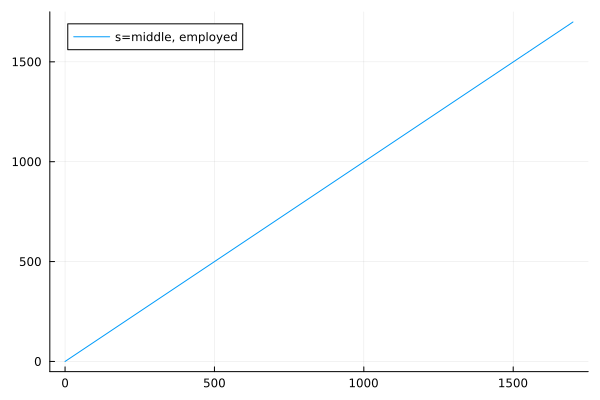

In [23]:
##sanity checks

println("Mass of distribution = ", sum(dist))
println("capitalout = ", capitalout)
println("laborout = ", laborout)

distI = dropdims(sum(dist, dims=(2,3)), dims=(2,3))  # sum over s,e
println("dist I=", sum(distI))

using Plots
plot(grid, save[:, 4, 2], label="s=middle, employed")


